# HW06
Input some other corpus of text input & see what awesome generated outputs you can come up with!
Based on http://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html

The corpus Bible KJV is found from http://www.gutenberg.org/cache/epub/10/pg10.txt

In [1]:
%matplotlib inline

## Preparing the Data

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return list(filter(lambda x: len(x) > 0, [unicodeToAscii(line) for line in lines]))

# Build the category_lines dictionary, a list of lines per category
lines = readLines('data/bible/bible_kjv_psalms.txt')

print(lines[0])
print(unicodeToAscii("O'Néàl"))

The Book of Psalms
O'Neal


## Creating the Network

We will interpret the output as the probability of the next letter. When sampling, the most likely output letter is used as the next input letter.

I added a second linear layer ``o2o`` (after combining hidden and output) to give it more muscle to work with. There's also a dropout layer, which `randomly zeros parts of its input <https://arxiv.org/abs/1207.0580>`__ with a given probability
(here 0.1) and is usually used to fuzz inputs to prevent overfitting. Here we're using it towards the end of the network to purposely add some chaos and increase sampling variety.

https://i.imgur.com/jzVrf7f.png (but the category input is removed)

In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        input_combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

Training
=========
Preparing for Training
----------------------

First of all, helper functions to get random pairs of (category, line):




In [4]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTraining():
    line = randomChoice(lines)
    return line

For each timestep (that is, for each letter in a training word) the inputs of the network will be ``(current letter, hidden state)`` and the outputs will be ``(next letter, next hidden state)``. So for each training set, we'll need a set of input letters, and a set of output/target letters.

Since we are predicting the next letter from the current letter for each
timestep, the letter pairs are groups of consecutive letters from the
line - e.g. for ``"ABCD<EOS>"`` we would create ("A", "B"), ("B", "C"),
("C", "D"), ("D", "EOS").

In [5]:
# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

For convenience during training we'll make a ``randomTrainingExample`` function that fetches a random line and turns them into the required (input, target) tensors.




In [6]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    line = randomTraining()
    input_line_tensor = Variable(inputTensor(line))
    target_line_tensor = Variable(targetTensor(line))
    return input_line_tensor, target_line_tensor

Training the Network
--------------------

In contrast to classification, where only the last output is used, we
are making a prediction at every step, so we are calculating loss at
every step.

The magic of autograd allows you to simply sum these losses at each step
and call backward at the end.




In [7]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(input_line_tensor, target_line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size()[0]):
        output, hidden = rnn(input_line_tensor[i], hidden)
        loss += criterion(output, target_line_tensor[i])

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.data[0] / input_line_tensor.size()[0]

To keep track of how long training takes I am adding a
``timeSince(timestamp)`` function which returns a human readable string:




In [8]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

Training is business as usual - call train a bunch of times and wait a
few minutes, printing the current time and loss every ``print_every``
examples, and keeping store of an average loss per ``plot_every`` examples
in ``all_losses`` for plotting later.




In [9]:
rnn = RNN(n_letters, 512, n_letters)

In [10]:
# n_iters = 100000
# print_every = 5000
# plot_every = 500
n_iters = 20000
print_every = 500
plot_every = 50
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 22s (500 2%) 3.1701
0m 44s (1000 5%) 3.5114
1m 7s (1500 7%) 2.8795
1m 30s (2000 10%) 2.9136
1m 53s (2500 12%) 2.6523
2m 15s (3000 15%) 2.8048
2m 38s (3500 17%) 3.0970
3m 0s (4000 20%) 2.7507
3m 20s (4500 22%) 2.6547
3m 41s (5000 25%) 2.5608
4m 2s (5500 27%) 2.0700
4m 24s (6000 30%) 2.4972
4m 44s (6500 32%) 2.1414
5m 5s (7000 35%) 2.1052
5m 25s (7500 37%) 3.0440
5m 46s (8000 40%) 2.3156
6m 5s (8500 42%) 2.0605
6m 25s (9000 45%) 2.1571
6m 48s (9500 47%) 2.2021
7m 9s (10000 50%) 2.7439
7m 30s (10500 52%) 2.2447
7m 47s (11000 55%) 2.0886
8m 6s (11500 57%) 2.4591
8m 27s (12000 60%) 2.2018
8m 48s (12500 62%) 2.2077
9m 10s (13000 65%) 2.2103
9m 31s (13500 67%) 2.4422
9m 52s (14000 70%) 2.0957
10m 14s (14500 72%) 1.9845
10m 35s (15000 75%) 2.2039
10m 56s (15500 77%) 1.9887
11m 18s (16000 80%) 2.4079
11m 40s (16500 82%) 2.3288
12m 1s (17000 85%) 2.1829
12m 24s (17500 87%) 2.1923
12m 45s (18000 90%) 2.0775
13m 5s (18500 92%) 1.9997
13m 24s (19000 95%) 1.8244
13m 45s (19500 97%) 1.9776
14m 5s 

Plotting the Losses
-------------------

Plotting the historical loss from all\_losses shows the network
learning:




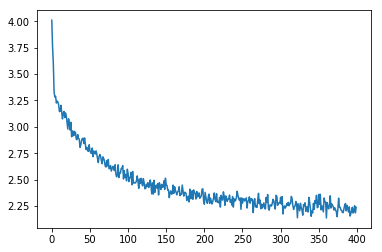

In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

Sampling the Network
====================

To sample we give the network a letter and ask what the next one is,
feed that in as the next letter, and repeat until the EOS token.

-  Create tensors for input category, starting letter, and empty hidden
   state
-  Create a string ``output_name`` with the starting letter
-  Up to a maximum output length,

   -  Feed the current letter to the network
   -  Get the next letter from highest output, and next hidden state
   -  If the letter is EOS, stop here
   -  If a regular letter, add to ``output_name`` and continue

-  Return the final name

.. Note::
   Rather than having to give it a starting letter, another
   strategy would have been to include a "start of string" token in
   training and have the network choose its own starting letter.




In [12]:
max_length = 100

# Sample from a category and starting letter
def sample(start_letter='A'):
    input = Variable(inputTensor(start_letter))
    hidden = rnn.initHidden()

    output_name = start_letter

    for i in range(max_length):
        output, hidden = rnn(input[0], hidden)
        topv, topi = output.data.topk(1)
        topi = topi[0][0]
        if topi == n_letters - 1:
            break
        else:
            letter = all_letters[topi]
            output_name += letter
        input = Variable(inputTensor(letter))

    return output_name

# Get multiple samples from one category and multiple starting letters
def samples(start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(start_letter))

In [13]:
samples('ABCTWH')

Aed in the LORd of thath that of the LORD is the LORD in the LaRD, ant of ine the wald the will the w
Ben the will to the witked, and the LORd in the LORD is the LORD is the willede for ming ine touthis 
Cere the LORD is the LO Dous all the withe will the will deat of the LORD is tout of the LORD is that
The LORD is the LORD is are the wall thes and to the LORD ise the LORD ise tout of
We the LORD is the LORD is the LORD,
He the LORD ise the LORD is the LORD, are the LORD is the LO Dor ais the LiRD is the LORD is the LORD
